In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from pymer4.models import Lmer,Lm
from matplotlib import cm
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
pd.set_option('display.max_columns', None)

In [3]:
concatenated_df = pd.read_pickle('./concatenated_dfn3_oct.pkl')
age = pd.read_pickle('./age_oct.pkl')


average age: 26.050588235294118
average age controls: 25.523043478260874
average age encephalitis: 28.807199999999998
average age schizophrenia: 23.2115


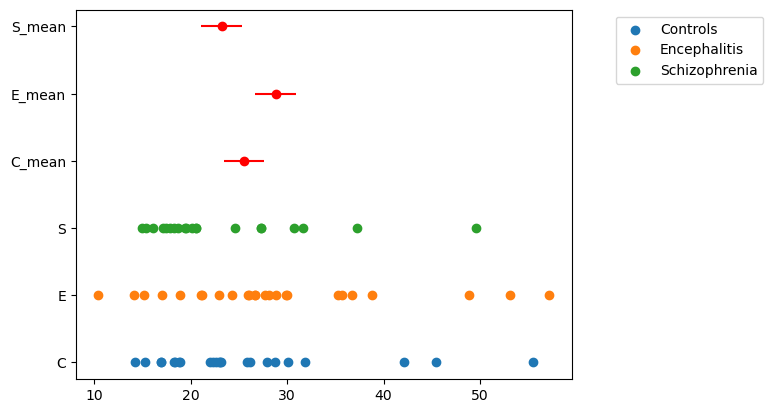

In [4]:
age['Group'] = age['Subject'].str[0]
age.tail(9)


# Session 1
print('average age:', np.mean(age.loc[age['Session']==1, 'Age']))
print('average age controls:', np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']))
print('average age encephalitis:', np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']))
print('average age schizophrenia:', np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']))

# plot age
plt.scatter(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='C')&(age['Session']==1)), 'Group'], label = 'Controls')
plt.scatter(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='E')&(age['Session']==1)), 'Group'], label = 'Encephalitis')
plt.scatter(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='S')&(age['Session']==1)), 'Group'], label = 'Schizophrenia')
plt.legend(bbox_to_anchor=(1.4, 1.0))
  
plt.errorbar(np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), "C_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')
plt.errorbar(np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']), "E_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')
plt.errorbar(np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']), "S_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')

plt.show()

In [5]:
# Subsets data
crs1 = concatenated_df['Session']==1
crs2 = concatenated_df['Session']==2
crs3 = concatenated_df['Session']==3
crs4 = concatenated_df['Session']==4

cri1 = concatenated_df['Group'] == 'C'
cri2 = concatenated_df['Group'] == 'E'
cri3 = concatenated_df['Group'] == 'S'
criC = cri1 & crs1
criE = cri2 & crs1
criS = cri3 & crs1

# Only data from session 1
#data = concatenated_df[crs1]
data=concatenated_df

# Add confusional arousals
cfsubj = ['E02','E03','E05','E06','E07','E16','E21','E22','C11','C12','C14','C18']
data['ConfArousal'] = 0
data.loc[concatenated_df.Subject.isin(cfsubj),'ConfArousal'] = 1
data.loc[:,'ConfArousal'] = data.loc[:,'ConfArousal'].astype('category')


# select frontal and posterior channels
chan_fp = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F8', 'F3','Fz', 'F4', 'F8', 'P3', 'Pz', 'P4', 'PO7', 'PO3', 
           'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
data_fp = concatenated_df[concatenated_df.Channel.isin(chan_fp)]

# add column indicating whether frontal or posterior electrode
#chan_f = ['Fz','F3','F4']
chan_f = ['Fz','F3','F4','F7','F8']
data_fp['Position'] = 'P'
data_fp.loc[data_fp.Channel.isin(chan_f),'Position'] = 'F'
data_fp.loc[:,'Session'] = data_fp.loc[:,'Session'].astype(int)


/tmp/ipykernel_405841/3263902381.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fp['Position'] = 'P'


## AGE COMPRISON between 20- and 20+

In [6]:
data_F = data_fp[data_fp['Position'] == 'F']
data_F.head()

Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
1903676   9498  0.673000  2423.08      2423.34  2423.57  2423.91      1.11   
1902669   8491  0.679381  2446.06      2446.33  2446.52  2447.30      1.53   
1904885  10707  0.679381  2446.04      2446.28  2446.48  2446.75      0.98   
1906138  11960  0.679381  2446.03      2446.27  2446.47  2446.75      0.98   
1907312  13134  0.679381  2446.02      2446.25  2446.47  2446.79      1.02   

         ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage  \
1903676  -46.707747   32.177395   78.885141  303.404390   0.900901      3   
1902669  -89.754462   38.805616  128.560078  476.148436   0.653595      3   
1904885 -117.820316   70.414380  188.234695  784.311231   1.020408      3   
1906138 -111.116778   73.118567  184.235346  767.647273   1.020408      3   
1907312  -55.017271   42.728858   97.746129  424.983169   0.980392      3   

        Channel  IdxChannel Group Subject Session    Age Machine ConfArousal  \
1903676      F3           7     C     C02       1  22.91       O           0   
1902669      F7           6     C     C02       1  22.91       O           0   
1904885      Fz           8     C     C02       1  22.91       O           0   
1906138      F4           9     C     C02       1  22.91       O           0   
1907312      F8          10     C     C02       1  22.91       O           0   

        Position  
1903676        F  
1902669        F  
1904885        F  
1906138        F  
1907312        F

In [7]:
#DATA_allF ---> rel_t session 1 all types first HOUR

data_F = data_fp[data_fp['Position'] == 'F'].reset_index()
#data_F = data_F[data_F['Session']==1]

data_F['N3_times'] = data_F['Start'].where(data_F['Stage'] == 3)
N3_start_time = data_F.groupby(['Subject','Session'])['N3_times'].transform('min')
data_F['N3_times'] = N3_start_time
data_F['time_rel'] = data_F['Start'] - data_F['N3_times']

#start_times = data_F.groupby(['Subject', 'Session'])['Start'].transform('min')

data_allF = data_F[(data_F['time_rel'] <= 0.6) & (data_F['time_rel'] >= 0)]
data_allF['Id'] = data_allF['Subject'] + '_' + data_allF['Session'].astype(str)
print(len(set(data_allF['Subject'])))
data_allF = data_allF.groupby('Id').filter(lambda x: len(x) >= 100)
print(len(set(data_allF['Subject'])))
data_allF.head()

67
65


/tmp/ipykernel_405841/3293505842.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_allF['Id'] = data_allF['Subject'] + '_' + data_allF['Session'].astype(str)


index   Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
0  1903676   9498  0.673000  2423.08      2423.34  2423.57  2423.91      1.11   
1  1902669   8491  0.679381  2446.06      2446.33  2446.52  2447.30      1.53   
2  1904885  10707  0.679381  2446.04      2446.28  2446.48  2446.75      0.98   
3  1906138  11960  0.679381  2446.03      2446.27  2446.47  2446.75      0.98   
4  1907312  13134  0.679381  2446.02      2446.25  2446.47  2446.79      1.02   

   ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage Channel  \
0  -46.707747   32.177395   78.885141  303.404390   0.900901      3      F3   
1  -89.754462   38.805616  128.560078  476.148436   0.653595      3      F7   
2 -117.820316   70.414380  188.234695  784.311231   1.020408      3      Fz   
3 -111.116778   73.118567  184.235346  767.647273   1.020408      3      F4   
4  -55.017271   42.728858   97.746129  424.983169   0.980392      3      F8   

   IdxChannel Group Subject Session    Age Machine ConfArousal Position  \
0           7     C     C02       1  22.91       O           0        F   
1           6     C     C02       1  22.91       O           0        F   
2           8     C     C02       1  22.91       O           0        F   
3           9     C     C02       1  22.91       O           0        F   
4          10     C     C02       1  22.91       O           0        F   

   N3_times  time_rel     Id  
0     0.673  0.000000  C02_1  
1     0.673  0.006381  C02_1  
2     0.673  0.006381  C02_1  
3     0.673  0.006381  C02_1  
4     0.673  0.006381  C02_1

In [8]:
result_df = data_allF.groupby('Id')['N3_times'].first().reset_index()
result_df[0:36]


Id  N3_times
0   C02_1  0.673000
1   C03_1  2.290675
2   C04_1  0.245244
3   C05_4  0.281653
4   C06_1  0.347028
5   C06_4  0.804019
6   C07_1  0.838603
7   C07_4  1.243039
8   C08_1  1.836106
9   C08_4  0.517881
10  C09_1  0.584272
11  C10_1  0.247275
12  C10_4  0.303353
13  C11_1  0.519064
14  C12_1  0.301583
15  C13_1  0.800669
16  C13_4  1.176403
17  C14_1  0.462619
18  C14_4  1.344044
19  C15_1  0.934231
20  C15_4  0.493289
21  C16_1  1.691692
22  C16_4  1.017597
23  C17_1  0.290100
24  C18_1  0.784144
25  C20_4  1.067494
26  C21_4  0.784522
27  C22_1  0.608797
28  C23_1  0.902664
29  C23_4  0.675117
30  C24_1  0.933681
31  C25_1  0.899947
32  E01_2  0.370378
33  E01_3  0.745633
34  E02_1  0.333803
35  E02_2  0.196806

In [9]:
data_allF[data_allF['Id'] == 'C06_4'].head(9)

index   Wave     Start  NegPeak  MidCrossing  PosPeak      End  \
23122  1725518  11034  0.804019  2894.75      2894.98  2895.19  2895.42   
23123  1724342   9858  0.804031  2894.79      2895.02  2895.22  2895.44   
23124  1730257  15773  0.804036  2894.80      2895.03  2895.24  2895.53   
23125  1725519  11035  0.858653  3091.46      3091.78  3092.03  3092.32   
23126  1727187  12703  0.858653  3091.46      3091.78  3092.03  3092.35   
23127  1724343   9859  0.858656  3091.49      3091.80  3092.02  3092.27   
23128  1730258  15774  0.859697  3095.17      3095.44  3095.58  3095.74   
23129  1725520  11036  0.861347  3101.19      3101.44  3101.77  3102.24   
23130  1727188  12704  0.861347  3101.21      3101.45  3101.80  3102.21   

       Duration  ValNegPeak  ValPosPeak         PTP       Slope  Frequency  \
23122      0.95 -112.914945   93.554086  206.469031  897.691439   1.052632   
23123      0.93  -63.102708   47.498473  110.601181  480.874701   1.075269   
23124      1.00  -84.831698   62.182987  147.014686  639.194286   1.000000   
23125      1.17 -113.585860   57.086864  170.672725  533.352265   0.854701   
23126      1.20 -120.873693   59.709821  180.583515  564.323484   0.833333   
23127      1.11  -74.640213   37.722547  112.362760  362.460517   0.900901   
23128      0.83  -62.658235   17.380582   80.038817  296.440064   1.204819   
23129      1.39  -45.195531   56.547552  101.743082  406.972329   0.719424   
23130      1.36  -41.775588   62.260654  104.036242  433.484341   0.735294   

       Stage Channel  IdxChannel Group Subject Session   Age Machine  \
23122      3      F3           7     C     C06       4  15.2       O   
23123      3      F7           6     C     C06       4  15.2       O   
23124      3      F8          10     C     C06       4  15.2       O   
23125      3      F3           7     C     C06       4  15.2       O   
23126      3      Fz           8     C     C06       4  15.2       O   
23127      3      F7           6     C     C06       4  15.2       O   
23128      3      F8          10     C     C06       4  15.2       O   
23129      3      F3           7     C     C06       4  15.2       O   
23130      3      Fz           8     C     C06       4  15.2       O   

      ConfArousal Position  N3_times  time_rel     Id  
23122           0        F  0.804019  0.000000  C06_4  
23123           0        F  0.804019  0.000011  C06_4  
23124           0        F  0.804019  0.000017  C06_4  
23125           0        F  0.804019  0.054633  C06_4  
23126           0        F  0.804019  0.054633  C06_4  
23127           0        F  0.804019  0.054636  C06_4  
23128           0        F  0.804019  0.055678  C06_4  
23129           0        F  0.804019  0.057328  C06_4  
23130           0        F  0.804019  0.057328  C06_4

In [10]:

#SEPARATE BINNED DATA_F in 20- and 20+

bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  # Adjust the number of bins as needed


print (len(bins_data_F))

#older group
bdf_o = bins_data_F[bins_data_F['Age'] >= 20]
print(len(bdf_o))

bdf_o = bdf_o.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_o['Group'] = bdf_o['Subject'].str[0]
mdf_o = bdf_o.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()

#younger group
bdf_y = bins_data_F[bins_data_F['Age'] < 20]
print(len(bdf_y))

bdf_y = bdf_y.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_y['Group'] = bdf_y['Subject'].str[0]
mdf_y = bdf_y.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()

#all
bins_data_F = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bins_data_F['Group'] = bins_data_F['Subject'].str[0]
mean_data_F = bins_data_F.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()


90851
41991
48860


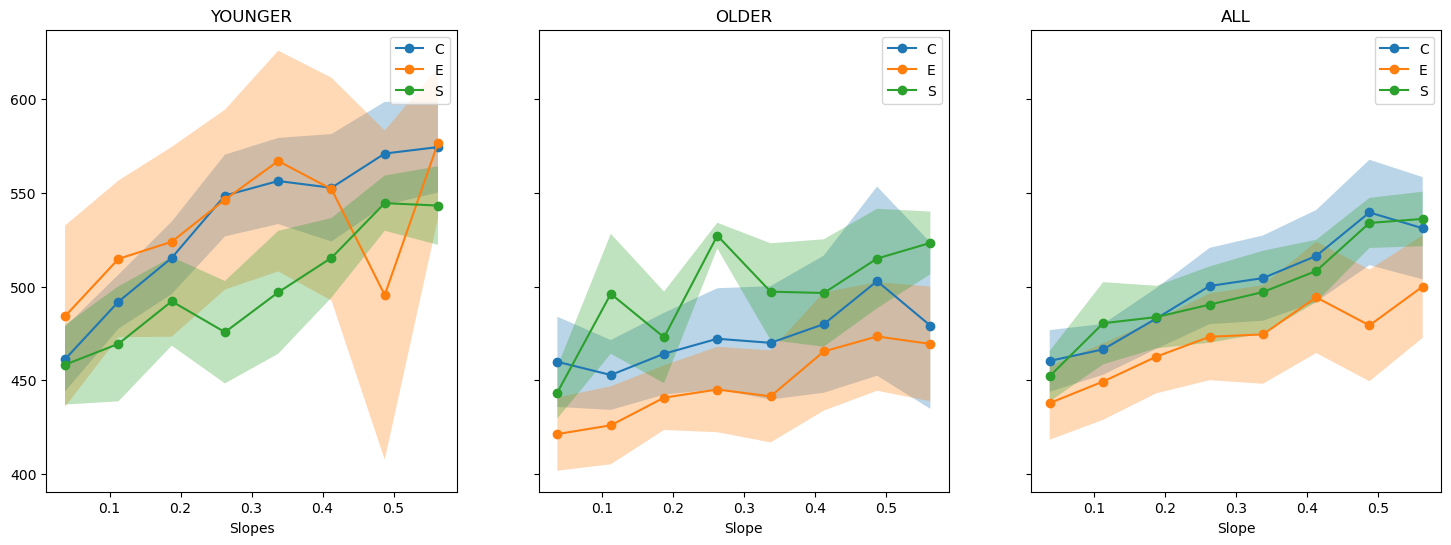

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6), sharex = 'all', sharey = 'all')

# Plot the individual curves for each name
mdf_o["time_rel_c"] = mdf_o["time_rel"].apply(lambda x: x.mid)
mdf_y["time_rel_c"] = mdf_y["time_rel"].apply(lambda x: x.mid)
mean_data_F["time_rel_c"] = mean_data_F["time_rel"].apply(lambda x: x.mid)
time_intervals = mdf_o['time_rel_c'].unique()

#YOUNGER
ax[0].set_title('YOUNGER')
for name, group in mdf_y.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].set_xlabel('Time')
ax[0].set_xlabel('Slopes')
ax[0].legend()

#OLDER
ax[1].set_title('OLDER')
for name, group in mdf_o.groupby('Group'):
    ax[1].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[1].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[1].set_xlabel('Time')
ax[1].set_xlabel('Slope')
ax[1].legend()

#ALL
ax[2].set_title('ALL')
for name, group in mean_data_F.groupby('Group'):
    ax[2].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[2].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[2].set_xlabel('Time')
ax[2].set_xlabel('Slope')
ax[2].legend()



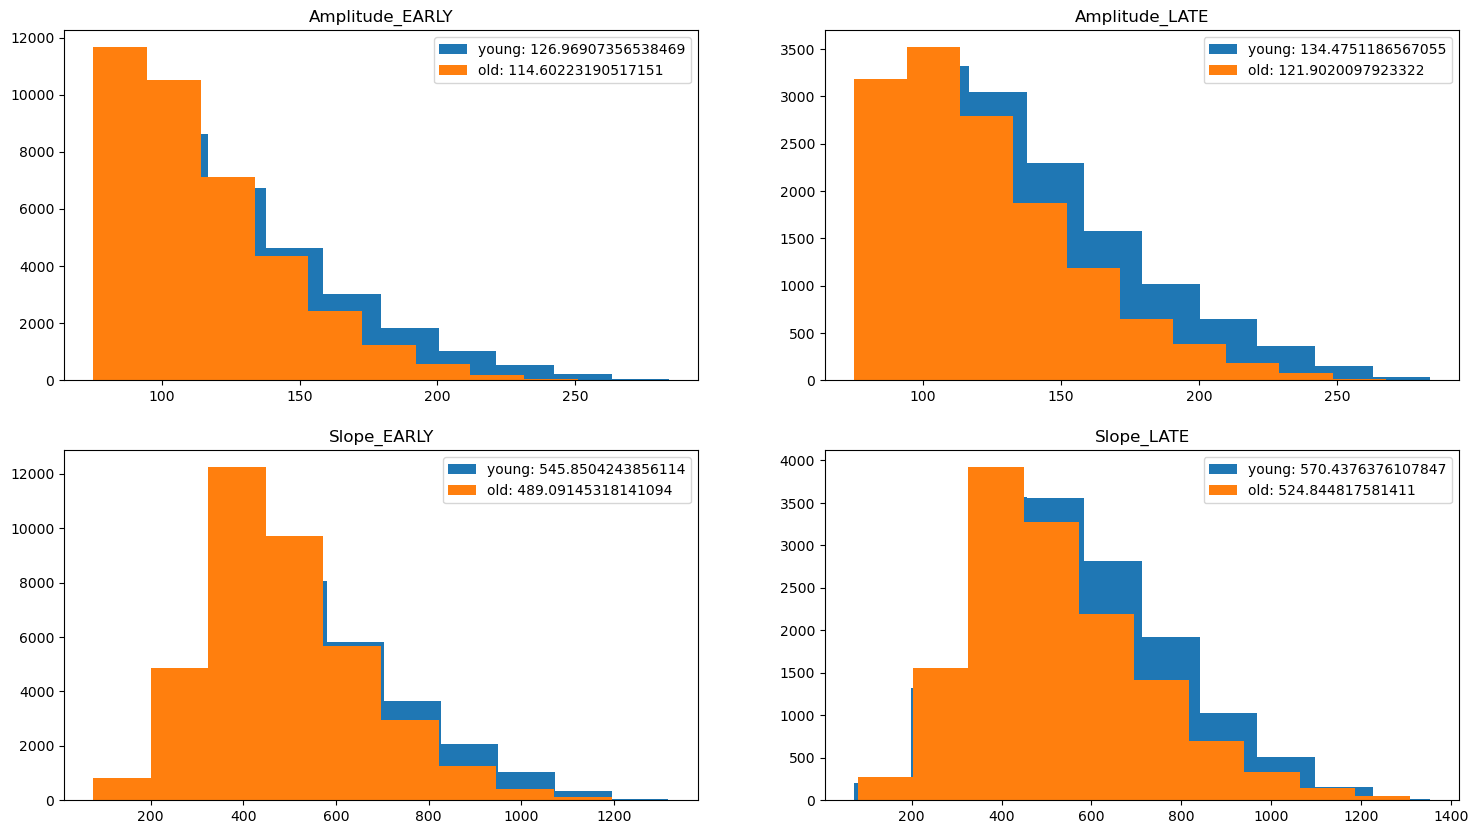

In [12]:
fig, ax = plt.subplots(2, 2, figsize = (18, 10))


data_young = data_allF[data_allF['Age'] < 20]
data_old = data_allF[data_allF['Age'] >= 20]


data_early_young = data_young[data_young['time_rel'] <= 0.3]
data_late_young = data_young[data_young['time_rel'] >= 0.5]
data_early_old = data_old[data_old['time_rel'] <= 0.3]
data_late_old = data_old[data_old['time_rel'] >= 0.5]


ax[0,0].hist(data_early_young.PTP, label = 'young: ' + str(np.mean(data_early_young.PTP)) )
ax[0,0].hist(data_early_old.PTP, label = 'old: ' + str(np.mean(data_early_old.PTP)))
ax[0,0].set_title('Amplitude_EARLY')
ax[0,0].legend()

ax[0,1].hist(data_late_young.PTP, label = 'young: ' + str(np.mean(data_late_young.PTP)) )
ax[0,1].hist(data_late_old.PTP, label = 'old: ' + str(np.mean(data_late_old.PTP)))
ax[0,1].set_title('Amplitude_LATE')
ax[0,1].legend()

ax[1,0].hist(data_early_young.Slope, label = 'young: ' + str(np.mean(data_early_young.Slope)) )
ax[1,0].hist(data_early_old.Slope, label = 'old: ' + str(np.mean(data_early_old.Slope)))
ax[1,0].set_title('Slope_EARLY')
ax[1,0].legend()

ax[1,1].hist(data_late_young.Slope, label = 'young: ' + str(np.mean(data_late_young.Slope)) )
ax[1,1].hist(data_late_old.Slope, label = 'old: ' + str(np.mean(data_late_old.Slope)))
ax[1,1].set_title('Slope_LATE')
ax[1,1].legend()


     index   Wave     Start  NegPeak  MidCrossing  PosPeak      End  Duration  \
0  1903676   9498  0.673000  2423.08      2423.34  2423.57  2423.91      1.11   
1  1902669   8491  0.679381  2446.06      2446.33  2446.52  2447.30      1.53   
2  1904885  10707  0.679381  2446.04      2446.28  2446.48  2446.75      0.98   
3  1906138  11960  0.679381  2446.03      2446.27  2446.47  2446.75      0.98   
4  1907312  13134  0.679381  2446.02      2446.25  2446.47  2446.79      1.02   

   ValNegPeak  ValPosPeak         PTP       Slope  Frequency  Stage Channel  \
0  -46.707747   32.177395   78.885141  303.404390   0.900901      3      F3   
1  -89.754462   38.805616  128.560078  476.148436   0.653595      3      F7   
2 -117.820316   70.414380  188.234695  784.311231   1.020408      3      Fz   
3 -111.116778   73.118567  184.235346  767.647273   1.020408      3      F4   
4  -55.017271   42.728858   97.746129  424.983169   0.980392      3      F8   

   IdxChannel Group Subject Session   

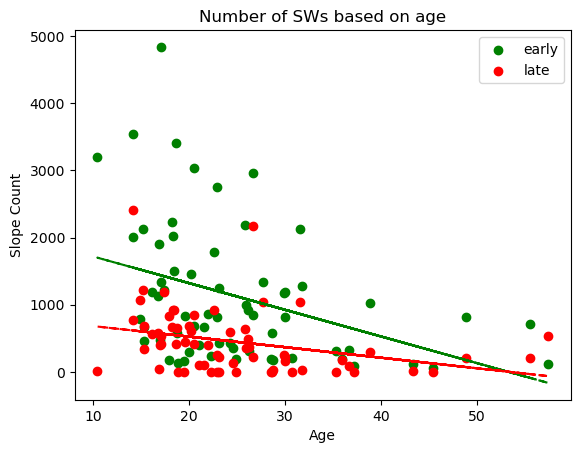

In [13]:

x_early_list = []
y_early_list = []
x_late_list = []
y_late_list = []

for name, Subject in data_allF.groupby('Subject'):
    data_early = Subject[Subject['time_rel'] <= 0.3]
    data_late = Subject[Subject['time_rel'] >= 0.5]

    print(data_early[0:5])

    x_early_list.append(Subject['Age'].unique()[0])
    y_early_list.append(data_early['Slope'].count())

    x_late_list.append(Subject['Age'].unique()[0])
    y_late_list.append(data_late['Slope'].count())

plt.scatter(x_early_list, y_early_list, marker='o', c='green', label='early')
plt.scatter(x_late_list, y_late_list, marker='o', c='red', label='late')

print(len(x_early_list))

early_fit = np.polyfit(x_early_list, y_early_list, 1)
late_fit = np.polyfit(x_late_list, y_late_list, 1)

plt.plot(x_early_list, np.polyval(early_fit, x_early_list), color='green', linestyle='--')
plt.plot(x_late_list, np.polyval(late_fit, x_late_list), color='red', linestyle='--')

plt.title('Number of SWs based on age')
plt.xlabel('Age')
plt.ylabel('Slope Count')
plt.legend()
plt.show()



# Age modelling for controls

In [14]:
# Obtain first hour of SWS:

#BINS DATA FRAME _ CONTROLS

bdf_c = data_allF.copy()
bdf_c = bdf_c[bdf_c['Group']=='C']
bdf_c['time_rel'] = pd.cut(bdf_c['time_rel'], bins=8)  # Adjust the number of bins as needed
print(len(bdf_c['Id'].unique()))

bdf_c = bdf_c.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_c['Group'] = bdf_c['Subject'].str[0]

age_c = age[age['Group']=='C']
#age_c = age_c[age_c['Session']==1]

bdf_c = bdf_c.merge(age_c)
bdf_c.head()


32


Session Subject          time_rel       Slope Group            Birthdate  \
0        1     C02  (-0.0006, 0.075]  532.037501     C  1994-05-28 00:00:00   
1        1     C02     (0.075, 0.15]  445.871812     C  1994-05-28 00:00:00   
2        1     C02     (0.15, 0.225]  456.799281     C  1994-05-28 00:00:00   
3        1     C02      (0.225, 0.3]  498.879013     C  1994-05-28 00:00:00   
4        1     C02      (0.3, 0.375]  570.776201     C  1994-05-28 00:00:00   

              Testdate    Age  
0  2017-04-26 00:00:00  22.91  
1  2017-04-26 00:00:00  22.91  
2  2017-04-26 00:00:00  22.91  
3  2017-04-26 00:00:00  22.91  
4  2017-04-26 00:00:00  22.91

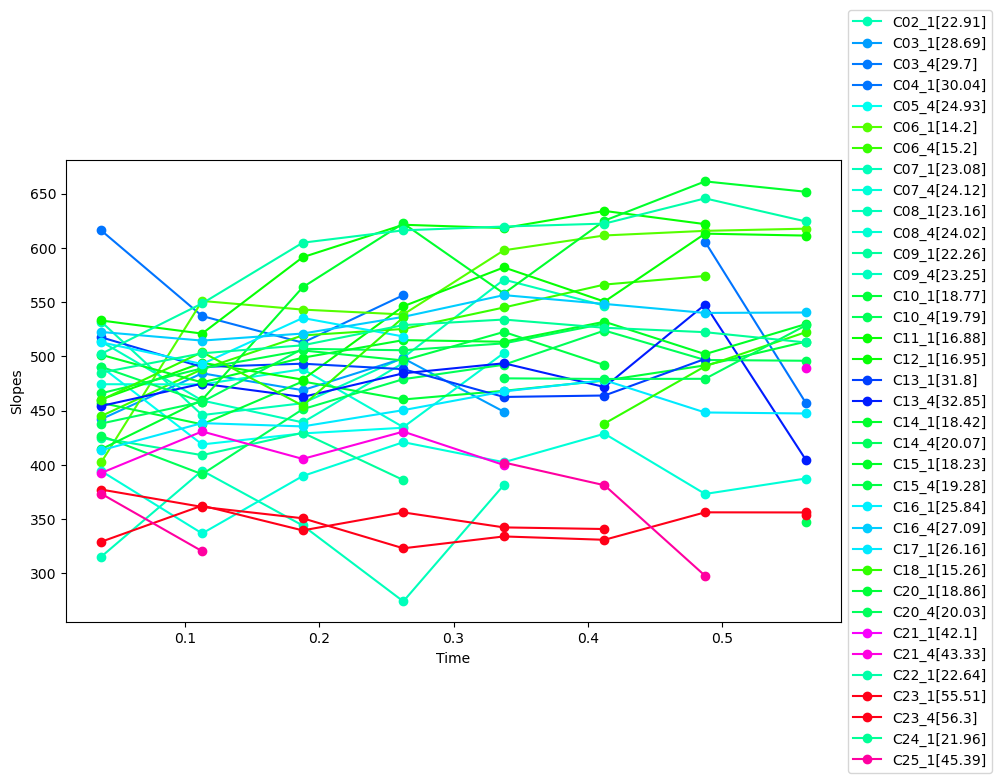

In [15]:

plt.figure(figsize=(10, 6))

# Plot the individual curves for each age

bdf_c["time_rel_c"] = bdf_c["time_rel"].apply(lambda x: x.mid).astype('object')
time_intervals = bdf_c['time_rel_c'].unique()
bdf_c['Id'] = bdf_c['Subject'] + '_' + bdf_c['Session'].astype(str)
for name, Id in bdf_c.groupby('Id'):
    plt.plot(time_intervals, Id['Slope'], marker='o', c = cm.hsv(Id['Age'].unique()[0]/50), label=str(name) + str(Id['Age'].unique()))

plt.xlabel('Time')
plt.ylabel('Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



In [16]:
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
#daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]
daf_c['sAge'] = daf_c['Age']/50
print(len(daf_c['Id'].unique()))

32


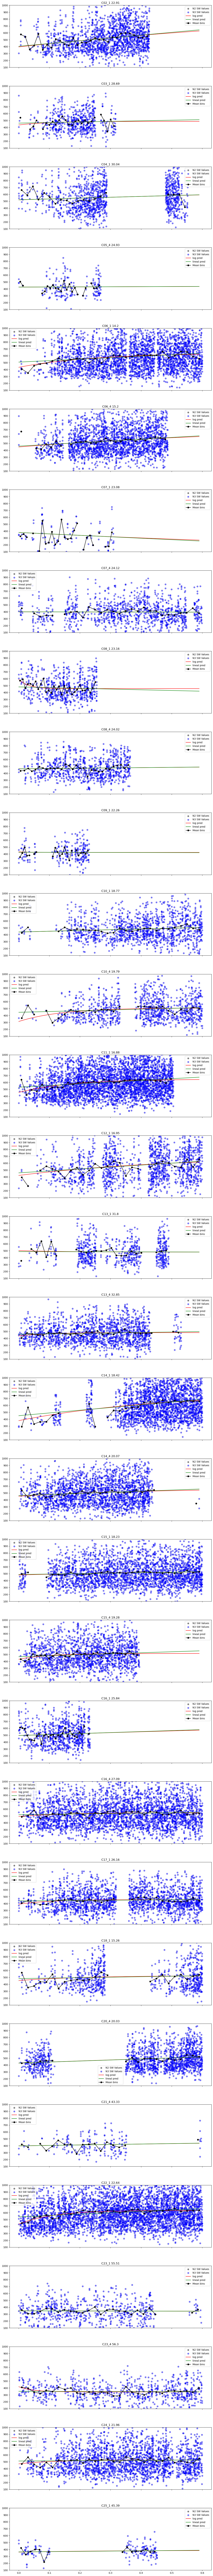

In [17]:

#LOG NO BINS
daf_c = data_allF.copy()
daf_c = daf_c[data_allF['Group']=='C']
#daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]
daf_c['sAge'] = daf_c['Age']/50

def func(x, a, b, c):
    return a - (b * np.exp(-x/c))

def func_l(x, m,n):
    return m + n*x


x_list = []
a_list = []
b_list = []
c_list = []

m_list = []
n_list = []

# Get the number of subplots needed
num_subplots = len(daf_c['Id'].unique())

# Create a figure and subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(15, 6*num_subplots),sharex=True, gridspec_kw={'hspace': 0.3})

for idx, (name, Subject) in enumerate(daf_c.groupby('Id')):

    x = Subject.time_rel.values
    y = Subject.Slope.values

    popt, pcov = curve_fit(func, x, y, bounds=([0, -1000, 0], [1000, 1000, 5]))

    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

    poptl, pcovl = curve_fit(func_l, x, y, bounds=([0, -1000], [1000, 1000]))

    coef_m = popt[0]
    coef_n = popt[1]


    m_list.append(coef_m)
    n_list.append(coef_n)



    # Plot on the respective subplot
    x_time = np.arange(0,0.6,0.01)
    Subject_2 = Subject[Subject['Stage']==2]
    Subject_3 = Subject[Subject['Stage']==3]
    axs[idx].scatter(Subject_2.time_rel.values, Subject_2.Slope.values,c='gray',label='N2 SW Values')
    axs[idx].scatter(Subject_3.time_rel.values, Subject_3.Slope.values,c='blue',label='N3 SW Values', alpha=0.5)
    axs[idx].plot(x_time, func(x_time, popt[0], popt[1], popt[2]), color='red', label='log pred')
    axs[idx].plot(x_time, func_l(x_time, poptl[0], poptl[1]), color='green', label='lineal pred')
    axs[idx].set_title(name + ' ' + str(Subject['Age'].unique()[0]))
    bins_Subject = Subject.copy()
    bins_Subject['time_rel'] = pd.cut(bins_Subject['time_rel'], bins=30)
    bins_Subject = bins_Subject.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
    bins_Subject["time_rel_c"] = bins_Subject["time_rel"].apply(lambda x: x.mid)
    time_intervals = bins_Subject['time_rel_c'].unique()
    axs[idx].plot(time_intervals, bins_Subject['Slope'], marker='o', c = 'black', label='Mean bins')
    axs[idx].set_ylim([100,1000])
    axs[idx].legend()


plt.show()
        



In [18]:
Subject.head()

index  Wave     Start  NegPeak  MidCrossing  PosPeak      End  \
131153  849566   813  0.899947  3240.10      3240.30  3240.52  3240.73   
131154  849838  1085  0.899964  3240.15      3240.35  3240.56  3240.79   
131155  849567   814  0.910497  3278.06      3278.31  3278.50  3278.70   
131156  849676   923  0.910503  3278.06      3278.31  3278.50  3278.71   
131157  849839  1086  0.916633  3300.22      3300.45  3300.66  3300.86   

        Duration  ValNegPeak  ValPosPeak         PTP       Slope  Frequency  \
131153      0.92  -49.872001   56.695168  106.567168  532.835842   1.086957   
131154      0.92  -47.438121   49.517960   96.956081  484.780404   1.086957   
131155      0.91  -53.994881   31.392611   85.387493  341.549970   1.098901   
131156      0.90  -50.055363   31.855328   81.910691  327.642766   1.111111   
131157      0.98  -40.748121   38.505378   79.253498  344.580427   1.020408   

        Stage Channel  IdxChannel Group Subject Session    Age Machine  \
131153      3      F3           7     C     C25       1  45.39       N   
131154      3      F4           9     C     C25       1  45.39       N   
131155      3      F3           7     C     C25       1  45.39       N   
131156      3      Fz           8     C     C25       1  45.39       N   
131157      3      F4           9     C     C25       1  45.39       N   

       ConfArousal Position  N3_times  time_rel     Id    sAge  
131153           0        F  0.899947  0.000000  C25_1  0.9078  
131154           0        F  0.899947  0.000017  C25_1  0.9078  
131155           0        F  0.899947  0.010550  C25_1  0.9078  
131156           0        F  0.899947  0.010556  C25_1  0.9078  
131157           0        F  0.899947  0.016686  C25_1  0.9078

 _____________ Fitted Parameters M:
M: 528.348198393333
N: -2.910232150417309
 _____________ Fitted Parameters N:
a: 12.588733979485006
b: -1520.9845929649323
c: 7.5999160704416235
[[ 3.43776798e+03 -8.50633366e+04 -2.66703224e+02]
 [-8.50633366e+04  4.79865265e+06  1.21418591e+04]
 [-2.66703224e+02  1.21418591e+04  3.24841884e+01]]


Text(0.5, 0.98, 'Slope analysis')

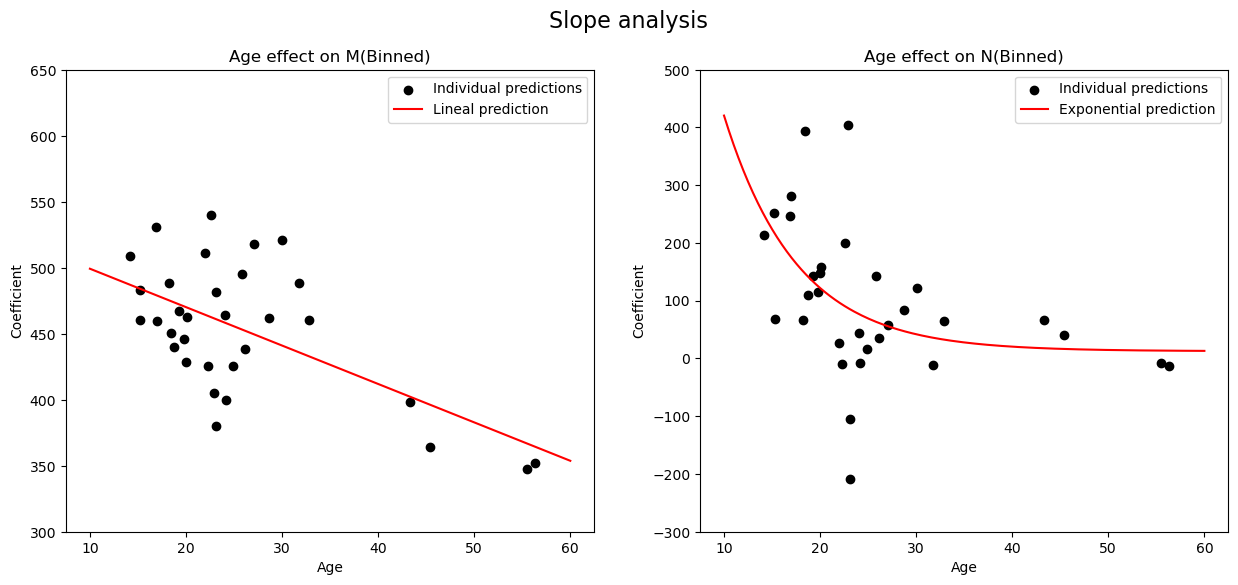

In [19]:
#LOG NO BINS


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func_l(x, m, n):
    return m + n*x

def func_exp(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
m_list = []
n_list = []


for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values
      
    popt, pcov = curve_fit(func_l, x, y,bounds=([0,-1000],[1000,1000]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_m = popt[0]
    coef_n = popt[1]

    x_list.append(Subject['Age'].unique()[0])
    m_list.append(coef_m)
    n_list.append(coef_n)

fig, ax = plt.subplots(1, 2, figsize = (15, 6))

splot = 0
coef_names = ['M','N']
total_coefs = []

for coef_list in [m_list,n_list]:
    y_list = coef_list

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)

    if splot == 0:
        
        popt_t, pcov_t = curve_fit(func_l, x_sorted, y_sorted,bounds=([0,-1000],[1000,1000]))

        print(" _____________ Fitted Parameters " + coef_names[splot]+":")
        print("M:", popt_t[0])
        print("N:", popt_t[1])

        total_coefs.append(popt_t[0])
        total_coefs.append(popt_t[1])


        x_ages = np.linspace(10,60,200)

        ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual predictions')
        ax[splot].plot(x_ages, func_l(x_ages, popt_t[0], popt_t[1]), c='red', label='Lineal prediction')

    else: 
        popt_t, pcov_t,info, mesg,ier= curve_fit(func_exp, x_sorted, y_sorted, bounds=([-10000, -15000, 0], [10000, 0, 1000]), full_output=True)

        print(" _____________ Fitted Parameters " + coef_names[splot]+":")
        print("a:", popt_t[0])
        print("b:", popt_t[1])
        print("c:", popt_t[2])
        print(pcov_t)

        total_coefs.append(popt_t[0])
        total_coefs.append(popt_t[1])
        total_coefs.append(popt_t[2])
    

        x_ages = np.linspace(10,60,200)

        ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual predictions')
        ax[splot].plot(x_ages, func_exp(x_ages, popt_t[0], popt_t[1], popt_t[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')


    if splot == 0:
        ax[splot].set_ylim([300,650])
    else:
        ax[splot].set_ylim([-300,500])

    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Slope analysis", fontsize=16)



In [20]:
print(total_coefs)

[528.348198393333, -2.910232150417309, 12.588733979485006, -1520.9845929649323, 7.5999160704416235]


In [21]:
age

Subject  Session            Birthdate             Testdate    Age Group
0       C02        1  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91     C
1       C03        1  1988-09-09 00:00:00  2017-05-18 00:00:00  28.69     C
2       C04        1  1987-05-24 00:00:00  2017-06-08 00:00:00  30.04     C
3       C06        1  2003-04-10 00:00:00  2017-06-22 00:00:00  14.20     C
4       C07        1  1994-06-05 00:00:00  2017-07-05 00:00:00  23.08     C
..      ...      ...                  ...                  ...    ...   ...
131     S07        4  2002-06-21 00:00:00  2019-03-28 00:00:00  16.77     S
132     S08        4  2003-05-09 00:00:00  2019-03-27 00:00:00  15.88     S
133     S11        4  2003-05-15 00:00:00  2019-11-07 00:00:00  16.48     S
134     S12        4  1998-03-04 00:00:00  2019-09-05 00:00:00  21.51     S
135     S15        4  2000-06-18 00:00:00  2020-02-20 00:00:00  19.67     S

[136 rows x 6 columns]

90851


[]

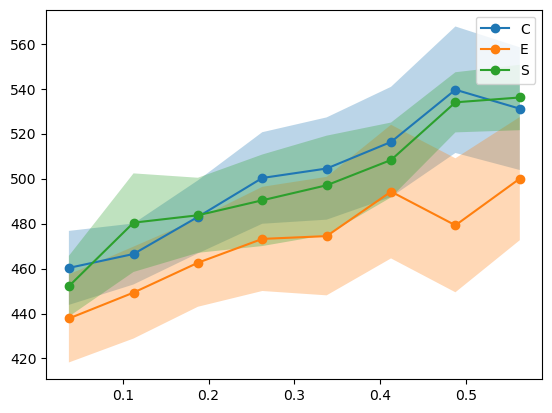

In [22]:
bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  
print (len(bins_data_F))

bdf = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf['Group'] = bdf['Subject'].str[0]
bdf["time_rel_c"] = bdf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdf = bdf.merge(age)

mdf = bdf.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()


for name, group in mdf.groupby('Group'):
    plt.plot(time_intervals, group['mean'], marker='o', label=name)
    plt.fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)
plt.legend()
plt.plot()



90851


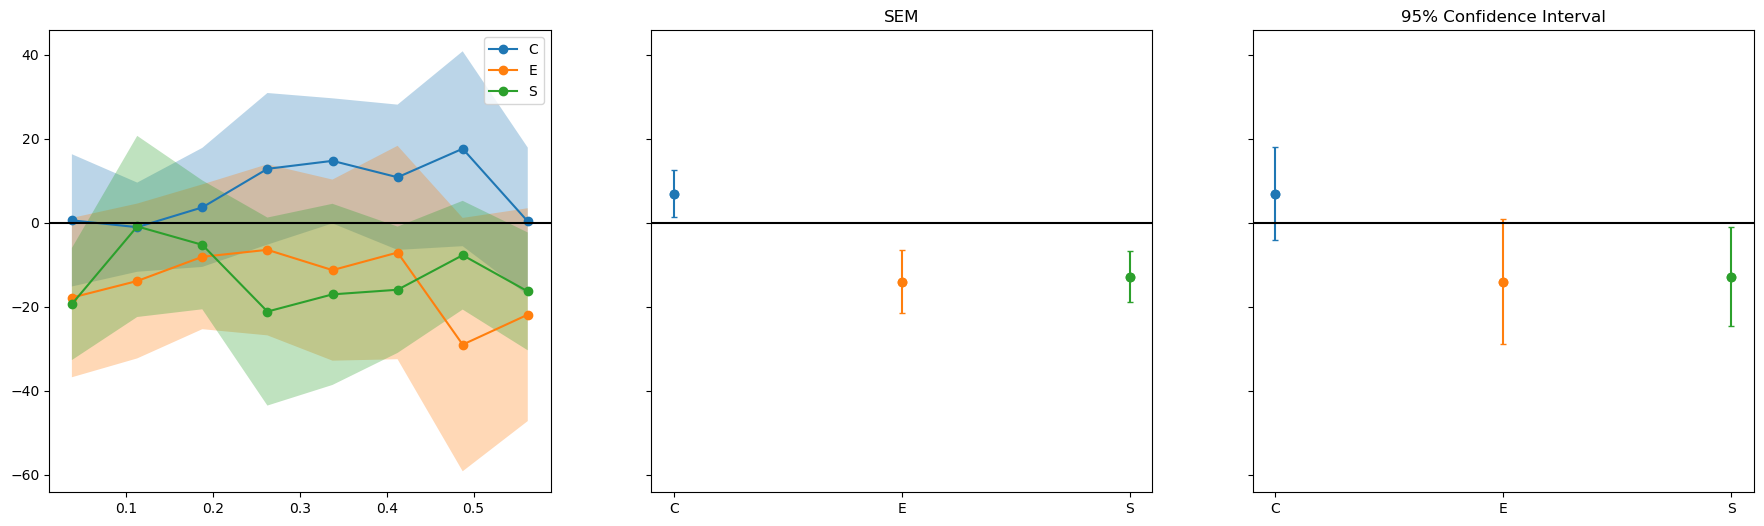

In [37]:
bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  
print (len(bins_data_F))

bdf = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf['Group'] = bdf['Subject'].str[0]
bdf["time_rel_c"] = bdf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdf = bdf.merge(age)

bdf['Age'] = pd.to_numeric(bdf['Age'], errors='coerce')
bdf['time_rel_c'] = pd.to_numeric(bdf['time_rel_c'], errors='coerce')

bdf['Slope_n'] = (
    total_coefs[0] +
    total_coefs[1] * bdf['Age'] +
    (total_coefs[2] - total_coefs[3] * np.exp(-bdf['Age'] / total_coefs[4])) * bdf['time_rel_c']
)

bdf['Slope_rel'] = bdf['Slope'] - bdf['Slope_n']

mdf = bdf.groupby(['Group', 'time_rel'])['Slope_rel'].agg(['mean', 'sem']).reset_index()
mdf_t = bdf.groupby(['Group'])['Slope_rel'].agg(['mean', 'sem']).reset_index()

# Plotting
fig, ax = plt.subplots(1, 3, figsize = (22, 6),sharey=True)
for name, group in mdf.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].axhline(0, color='black')
ax[0].legend()

for name, group in mdf_t.groupby('Group'):
    ax[1].scatter(name,group['mean'])
    ax[1].errorbar(name, group['mean'], yerr=group['sem'],capsize=2, marker="o")
ax[1].axhline(0, color='black')
ax[1].set_title('SEM')

for name, group in mdf_t.groupby('Group'):
    ax[2].scatter(name,group['mean'])
    ax[2].errorbar(name, group['mean'], yerr=group['sem']*1.96,capsize=2, marker="o")
ax[2].axhline(0, color='black')
ax[2].set_title('95% Confidence Interval')
plt.show()


In [24]:
model = Lmer('Slope_rel ~ time_rel_c*Age*Group + (1|Subject)', data=bdf)
model.fit()



print(model.coefs)

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "time_rel". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Birthdate". Fall back to string conversion. The error is: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  warnings.warn('Error while trying to convert '
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Testdate". Fall back to string conversion. The error is: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  warnings.warn('Error while trying to convert '


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: Slope_rel~time_rel_c*Age*Group+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 672	 Groups: {'Subject': 56.0}

Log-likelihood: -3041.219 	 AIC: 6110.437

Random effects:

                 Name       Var     Std
Subject   (Intercept)  4199.240  64.802
Residual               1863.873  43.173

No random effect correlations specified

Fixed effects:

                         Estimate      2.5_ci     97.5_ci         SE  \
(Intercept)            -16.544492  -99.929780   66.840795  42.544296   
time_rel_c              94.971725   -2.708501  192.651952  49.837766   
Age                      0.571498   -2.548492    3.691489   1.591861

In [25]:
# DATA

# x is a matrix one column per participant, one row per time  70 * 8
# age is a vector of 70 * 1 values
# group is a matrix of one column per participant, 70 * 3 rows (is_control, is_enc, is_sq)

# X is a matrix with all data above:  70 * 12(8+1+3) 

# PARAMETERS
# mi is a vector of 70 values
# mage is a scalar
# mgroup is a vector of 3 values (control, enc, sq)


# Y = 8*70



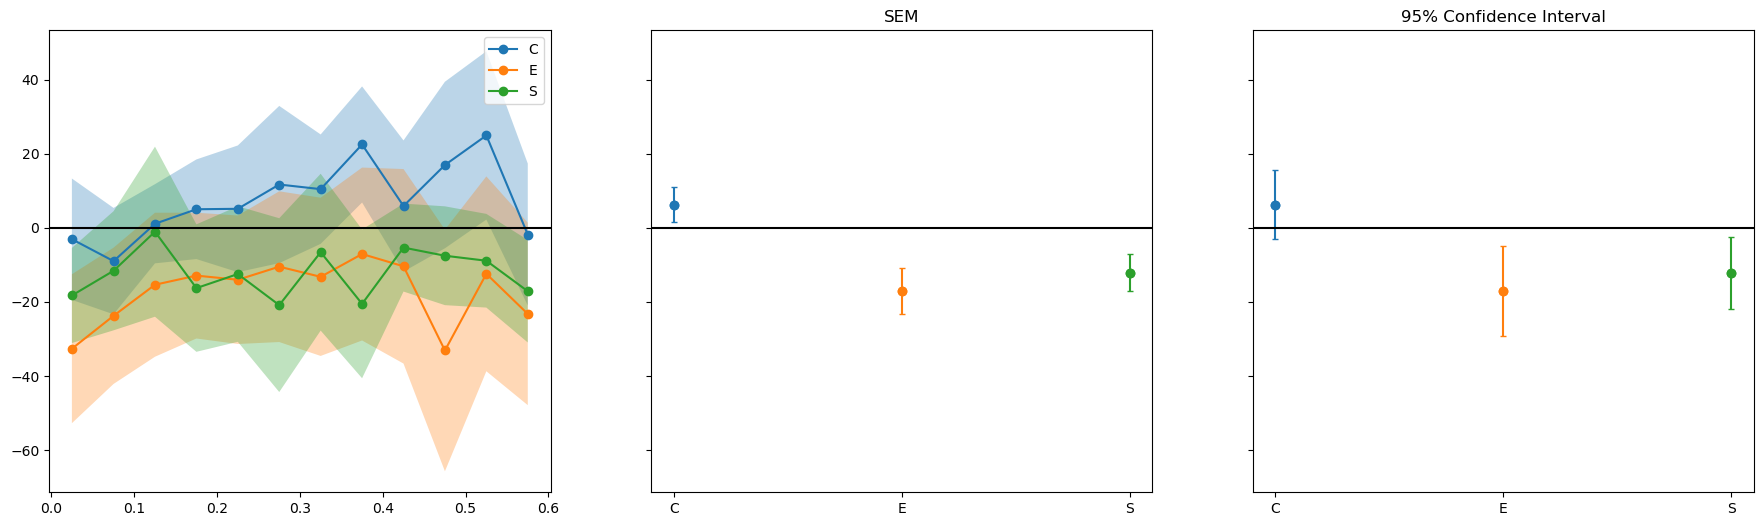

In [26]:
daf = data_allF.copy()
daf = daf[daf['Session']==1]
daf['Slope_n'] = (
    total_coefs[0] +
    total_coefs[1] * daf['Age'] +
    (total_coefs[2] - total_coefs[3] * np.exp(-daf['Age'] / total_coefs[4])) * daf['time_rel']
)

daf['Slope_rel'] = daf['Slope'] - daf['Slope_n']
bdaf = daf.copy()
bdaf['time_rel'] = pd.cut(bdaf['time_rel'], bins=12)  
bdaf = bdaf.groupby(['Session','Subject','time_rel'])['Slope_rel'].mean().reset_index()
bdaf['Group'] = bdaf['Subject'].str[0]
bdaf["time_rel_c"] = bdaf["time_rel"].apply(lambda x: x.mid)
time_intervals = bdaf['time_rel_c'].unique()
age_1 = age[age['Session']==1]
bdaf = bdaf.merge(age)

bdaf['Age'] = pd.to_numeric(bdaf['Age'], errors='coerce')
bdaf['time_rel_c'] = pd.to_numeric(bdaf['time_rel_c'], errors='coerce')

mdaf = bdaf.groupby(['Group', 'time_rel'])['Slope_rel'].agg(['mean', 'sem']).reset_index()

# Plotting
fig, ax = plt.subplots(1, 3, figsize = (22, 6),sharey=True)
for name, group in mdaf.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].axhline(0, color='black')
ax[0].legend()

for name, group in mdf_t.groupby('Group'):
    ax[1].scatter(name,group['mean'])
    ax[1].errorbar(name, group['mean'], yerr=group['sem'],capsize=2, marker="o")
ax[1].axhline(0, color='black')
ax[1].set_title('SEM')

for name, group in mdf_t.groupby('Group'):
    ax[2].scatter(name,group['mean'])
    ax[2].errorbar(name, group['mean'], yerr=group['sem']*1.96,capsize=2, marker="o")
ax[2].axhline(0, color='black')
ax[2].set_title('95% Confidence Interval')
plt.show()


In [27]:
mdaf.head()


Group         time_rel      mean        sem
0     C  (-0.0006, 0.05] -3.058443  16.381754
1     C      (0.05, 0.1] -8.977523  14.361703
2     C      (0.1, 0.15]  1.108321  10.685729
3     C      (0.15, 0.2]  5.023513  13.448199
4     C      (0.2, 0.25]  5.144499  17.102350

In [28]:
mdf.head()


Group         time_rel      mean        sem
0     C  (-0.0006, 0.05] -3.520726  16.469868
1     C      (0.05, 0.1] -8.790381  14.376354
2     C      (0.1, 0.15]  1.238629  10.670497
3     C      (0.15, 0.2]  5.258459  13.462432
4     C      (0.2, 0.25]  5.199661  17.110434

In [29]:
model = Lmer('Slope_rel ~ time_rel*Age*Group + (1|Subject)', data=daf)
model.fit()


print(model.coefs)

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope_rel~time_rel*Age*Group+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 90851	 Groups: {'Subject': 56.0}

Log-likelihood: -601166.129 	 AIC: 1202360.258

Random effects:

                 Name        Var      Std
Subject   (Intercept)   4917.102   70.122
Residual               32657.457  180.714

No random effect correlations specified

Fixed effects:

                       Estimate      2.5_ci     97.5_ci         SE  \
(Intercept)           16.109557  -69.098772  101.317887  43.474436   
time_rel               7.423487  -39.260150   54.107124  23.818620   
Age                   -0.590622   -3.787108    2.605864   1.630890   
GroupE               -10.198600 -139.202380  118.805181  65.819465   
GroupS               -12.361496 -161.805916  137.082924  76.248554   
time_rel:Age           0.964789   -1.110097    3.039675   1.058635   
time_rel:GroupE     -124.478245 -188.625463  -60.331028  32.728774  

In [30]:
bdf.head()



Session Subject         time_rel       Slope Group  time_rel_c  \
0        1     C02  (-0.0006, 0.05]  506.886023     C      0.0247   
1        1     C02      (0.05, 0.1]  442.806214     C      0.0750   
2        1     C02      (0.1, 0.15]  464.073783     C      0.1250   
3        1     C02      (0.15, 0.2]  460.117441     C      0.1750   
4        1     C02      (0.2, 0.25]  460.774798     C      0.2250   

             Birthdate             Testdate    Age     Slope_n  Slope_rel  
0  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  463.829200  43.056823  
1  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  468.216541 -25.410327  
2  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  472.577715  -8.503932  
3  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  476.938889 -16.821449  
4  1994-05-28 00:00:00  2017-04-26 00:00:00  22.91  481.300063 -20.525265

 _____________ Fitted Parameters A:
a: -4462.302639478295
b: -5222.1618663706895
c: 999.9999999997399
 _____________ Fitted Parameters B:
a: 107.71473119587387
b: -386.4193116340451
c: 15.01097337115544
 _____________ Fitted Parameters C:
a: 2.536975716316125
b: -5.771529195291882e-12
c: 999.9999833073349


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0.98, 'Slope analysis')

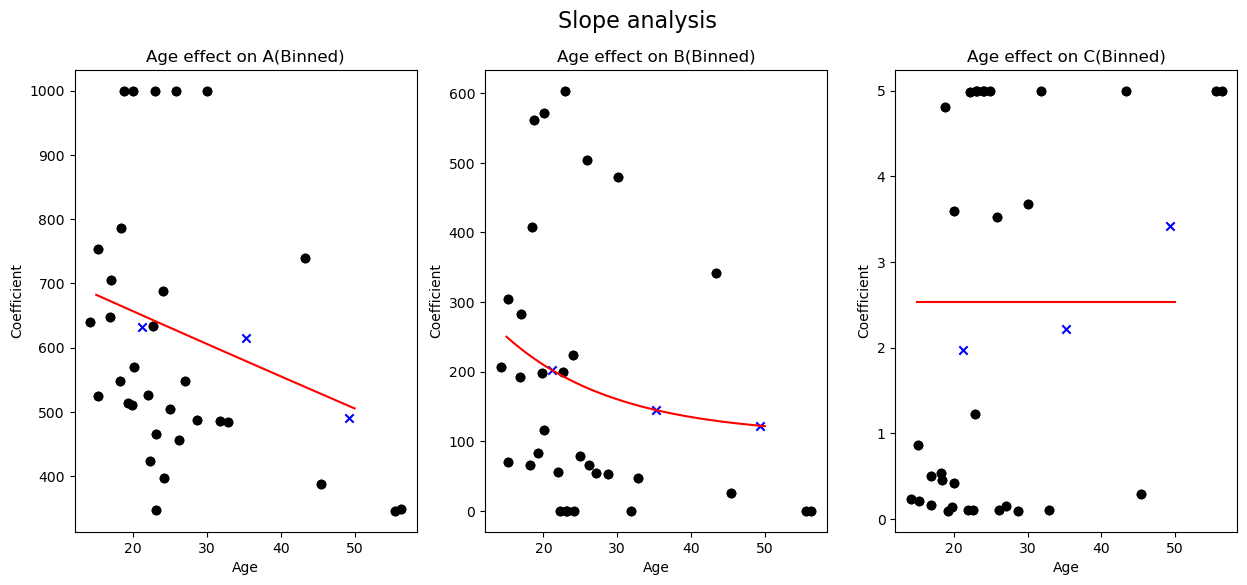

In [31]:

#LOG NO BINS


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c)) 




x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,0,0],[1000,1000,5]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]
    

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)
   

fig, ax = plt.subplots(1, 3, figsize = (15, 6))


splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 3
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])
    


    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    


    splot = splot + 1


fig.suptitle("Slope analysis", fontsize=16)



 _____________ Fitted Parameters A:
a: -528.3170668296908
b: -728.6265173928884
c: 999.9999931577885
 _____________ Fitted Parameters B:
a: -110.4290468692478
b: -189.44363745071516
c: 999.999999999862
 _____________ Fitted Parameters C:
a: 3.1325076795229854
b: -1.006435579721319e-10
c: 999.9085232695315


Text(0.5, 0.98, 'Amplitude analysis')

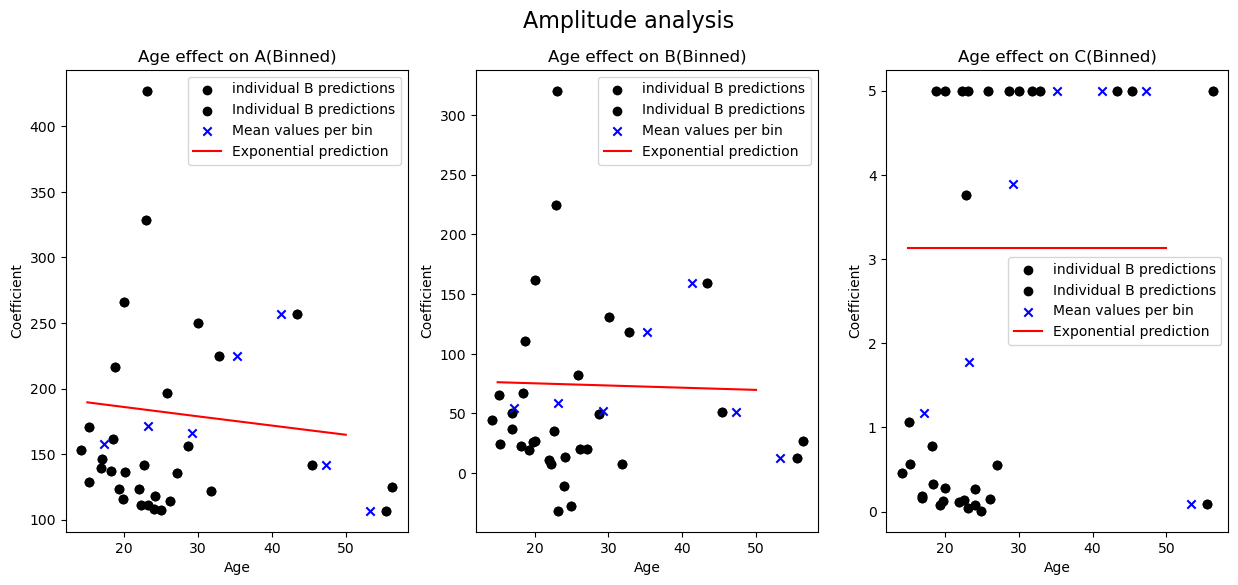

In [32]:
#LOG NO BINS AMPLITUDE


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.PTP.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,-1000,0],[1000,1000,5]))

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

fig, ax = plt.subplots(1, 3, figsize = (15, 6))




splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 7
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])

    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Amplitude analysis", fontsize=16)


 _____________ Fitted Parameters A:
a: 139.1033463587717
b: -3218.6900720610142
c: 9.43041252209742
 _____________ Fitted Parameters B:
a: 89.1030162078478
b: -4123.873370383997
c: 8.875173701797113
 _____________ Fitted Parameters C:
a: -0.0512568447522548
b: -3.778726250322365
c: 11.301863448544932


Text(0.5, 0.98, 'Amplitude analysis')

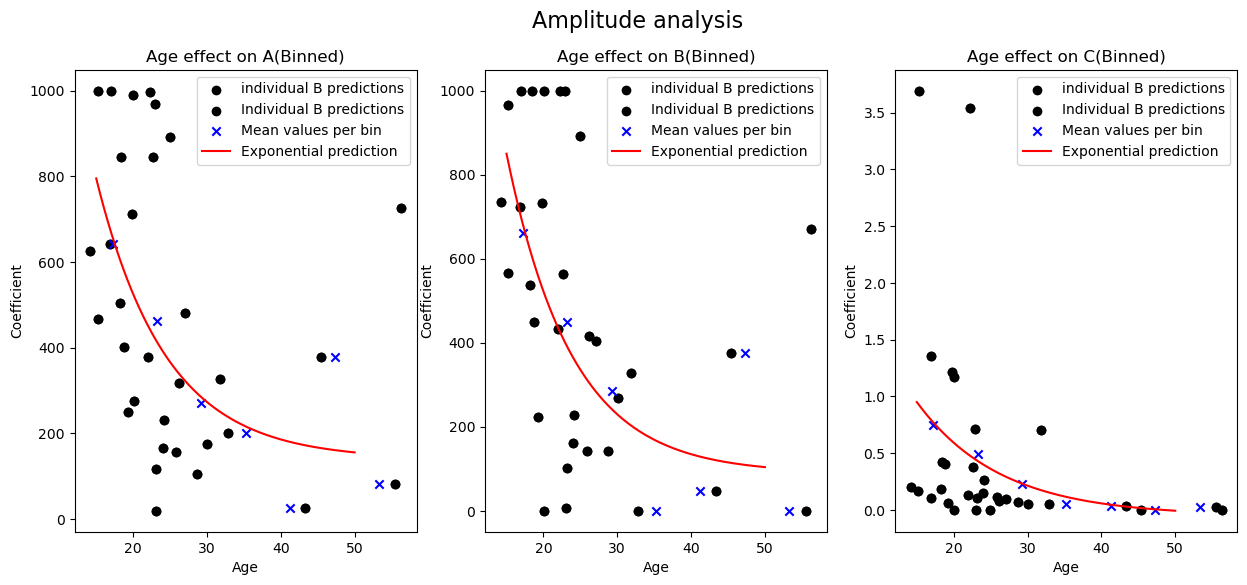

In [33]:
#LOG NO BINS NUMBER


daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf_c['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]


daf_c['sAge'] = daf_c['Age']/50


def func(x, a, b, c):
    return a  - (b * np.exp(-x/c))


x_list = []
a_list = []
b_list = []
c_list = []



for name, Subject in daf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)

    bins_Subject = Subject.copy()
    bins_Subject['time_rel'] = pd.cut(bins_Subject['time_rel'], bins=8)  # Adjust the number of bins as needed
    bins_Subject = bins_Subject.groupby(['Session','Subject','time_rel'])['Slope'].count().reset_index()
    bdf_c['Group'] = bdf_c['Subject'].str[0]
    bins_Subject["time_rel_c"] = bins_Subject["time_rel"].apply(lambda x: x.mid).astype('object')
    times_Subject = bins_Subject['time_rel_c'].unique()
    
    x = bins_Subject.time_rel_c.values
    y = bins_Subject.Slope.values
      
    popt, pcov = curve_fit(func, x, y,bounds=([0,0,0],[1000,1000,5]))

    if popt[2] > 4:
        popt[2] = 0

    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef_a = popt[0]
    coef_b = popt[1]
    coef_c = popt[2]

    x_list.append(Subject['Age'].unique()[0])
    a_list.append(coef_a)
    b_list.append(coef_b)
    c_list.append(coef_c)

fig, ax = plt.subplots(1, 3, figsize = (15, 6))




splot = 0
coef_names = ['A','B','C']

for coef_list in [a_list,b_list,c_list]:
    y_list = coef_list

    ax[splot].scatter(x_list, y_list, marker='o', c='black', label='individual B predictions')

    sorted_data = sorted(zip(x_list, y_list))
    x_sorted, y_sorted = zip(*sorted_data)
    x_sorted = np.array(x_sorted)
    y_sorted = np.array(y_sorted)


    num_bins = 7
    bin_edges = np.linspace(min(x_sorted), max(x_sorted), num_bins + 1)
    bin_indices = np.digitize(x_sorted, bin_edges)

    bin_means = [y_sorted[bin_indices == i].mean() for i in range(1, num_bins + 1)]
    bin_centers = [np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(0, num_bins)]

    popt_t_bin, pcov_t_bin = curve_fit(func, bin_centers, bin_means, bounds=([-10000, -15000, 0], [10000, 0, 1000]))

    print(" _____________ Fitted Parameters " + coef_names[splot]+":")
    print("a:", popt_t_bin[0])
    print("b:", popt_t_bin[1])
    print("c:", popt_t_bin[2])

    x_ages = np.linspace(15,50,200)

    ax[splot].scatter(x_sorted, y_sorted, marker='o', c='black', label='Individual B predictions')
    ax[splot].scatter(bin_centers, bin_means, marker='x', c='blue', label='Mean values per bin')
    ax[splot].plot(x_ages, func(x_ages, popt_t_bin[0], popt_t_bin[1], popt_t_bin[2]), c='red', label='Exponential prediction')

    ax[splot].set_title('Age effect on ' + coef_names[splot] +'(Binned)')
    ax[splot].set_xlabel('Age')
    ax[splot].set_ylabel('Coefficient')
    ax[splot].legend()


    splot = splot + 1


fig.suptitle("Amplitude analysis", fontsize=16)

NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN


[]

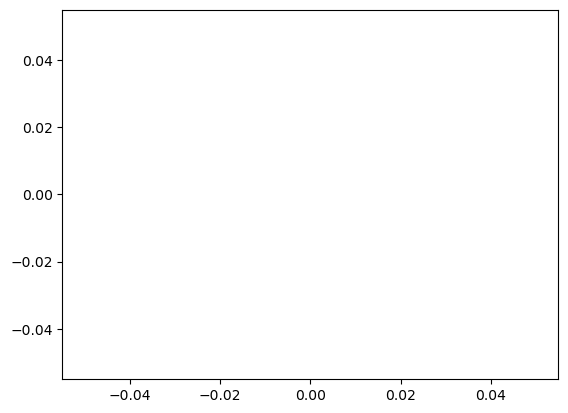

In [34]:
#LOG WITH BINS




#CONTROL SWA found

bdf_c = bdf_c

bdf_c['Id'] = bdf_c['Subject'] + '_' + bdf_c['Session'].astype(str)
bdf_c['sAge'] = bdf_c['Age']/50


def func(x, a, b, c):

    return a  + (b * np.exp(-x/c))


for name, Subject in bdf_c.groupby('Id'):
    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel_c.values
    y = Subject.Slope.values
    
    try:
        popt, pcov = curve_fit(func, x, y)
    

        #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
        coef = popt[1]
        #age = Subject['sAge'].unique()[0]
        plt.scatter(age,coef, color='black')

    except:
        print('NAN')

    #print(Subject['sAge'].unique()[0])
    #print(coef)
   
    
    
plt.plot()

C25_1
[0.0372 0.11249999999999999 0.1875 0.2625 0.3375 0.4125
 0.48750000000000004 0.5625]
524.72200078273
-60.86652844090457
0.09530622445393558


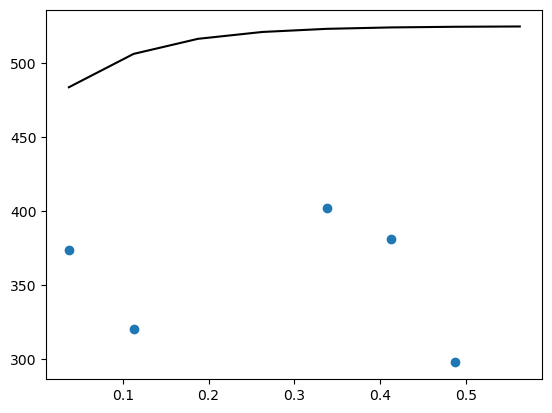

In [35]:
print(name)
plt.scatter(Subject.time_rel_c,Subject.Slope.values)
print(x)
print(popt[0])
print(popt[1])
print(popt[2])
x = Subject.time_rel_c.values.astype(float)
plt.plot(x, func(x,popt[0],popt[1],popt[2]), color='black')

## SQRT PRED PLOT

In [36]:
daf_c = data_allF[data_allF['Group']=='C']


#CONTROL SWA found

daf_c = daf_c[daf_c['Subject'].isin(daf['Subject'].value_counts()[daf_c['Subject'].value_counts() >= 20].index)]

daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c['sAge2'] = daf_c['sAge']**2
daf_c['sAge3'] = daf_c['sAge']**3
daf_c['sAge4'] = daf_c['sAge']**4
daf_c['sqrt_t'] = np.sqrt(daf_c['time_rel'])
sAge_values = np.arange(0.2,1,0.01)
sAge_values2 = sAge_values**2
sAge_values3 = sAge_values**3
sAge_values4 = sAge_values**4


for name, Subject in daf_c.groupby('Id'):
    model_id = Lm('Slope ~ sqrt_t', data=Subject)
    result = model_id.fit()
    coef = result['Estimate'][1]
    #age = Subject['sAge'].unique()[0]
    plt.scatter(age,coef, color='black')

#Sqrt deg 1:

model1 = Lm('Slope ~ sqrt_t * (sAge)', data=daf_c)
model1.fit()
plt.plot(sAge_values, model1.coefs['Estimate'][1] 
                                                + model1.coefs['Estimate'][3]*sAge_values 
                                                ,label = 'deg1')

#Sqrt deg 2:

model2 = Lm('Slope ~ sqrt_t * (sAge + sAge2)', data=daf_c)
model2.fit()
plt.plot(sAge_values, model2.coefs['Estimate'][1] 
                                                + model2.coefs['Estimate'][4]*sAge_values 
                                                + model2.coefs['Estimate'][5]*sAge_values2 
                                                ,label = 'deg2')

#Sqrt deg 3:

model3 = Lm('Slope ~ sqrt_t * (sAge + sAge2 + sAge3)', data=daf_c)
model3.fit()
plt.plot(sAge_values, model3.coefs['Estimate'][1] 
                                                + model3.coefs['Estimate'][5]*sAge_values
                                                + model3.coefs['Estimate'][6]*sAge_values2
                                                + model3.coefs['Estimate'][7]*sAge_values3
                                                ,label = 'deg3')


#Sqrt deg 4:

model4 = Lm('Slope ~ sqrt_t * (sAge + sAge2 + sAge3 + sAge4)', data=daf_c)
model4.fit()
plt.plot(sAge_values, model4.coefs['Estimate'][1] 
                                                + model4.coefs['Estimate'][6]*sAge_values 
                                                + model4.coefs['Estimate'][7]*sAge_values2
                                                + model4.coefs['Estimate'][8]*sAge_values3
                                                + model4.coefs['Estimate'][9]*sAge_values4
                                                ,label = 'deg4')

plt.ylim([-300,700])
plt.legend()
plt.show()





IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

## LINE PRED PLOT

/tmp/ipykernel_2747101/2835078309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/2835078309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50
/tmp/ipykernel_2747101/2835078309.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2047	 R^2: 0.001	 R^2_adj: 0.000

Log-likelihood: -13446.054 	 AIC: 26896.108	 BIC: 26907.356

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 902	 R^2: 0.003	 R^2_adj: 0.001

Log-likelihood: -5807.964 	 AIC: 11619.929	 BIC: 11629.538

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 466	 R^2: 0.003	 R^2_adj: 0.000

Log-likelihood: -2972.719 	 AIC: 5949.438	 BIC: 5957.726

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2500	 R^2: 0.002	 R^2_adj: 0.001

Log-likelihood: -16762.757 	 AIC: 33529.515	 BI

/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 1130	 R^2: 0.000	 R^2_adj: -0.001

Log-likelihood: -7311.558 	 AIC: 14627.116	 BIC: 14637.176

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 1701	 R^2: 0.001	 R^2_adj: 0.001

Log-likelihood: -10866.761 	 AIC: 21737.521	 BIC: 21748.399

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 4434	 R^2: 0.024	 R^2_adj: 0.024

Log-likelihood: -29964.563 	 AIC: 59933.127	 BIC: 59945.921

Fixed effects:

Formula: Slope~time_rel

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2443	 R^2: 0.000	 R^2_adj: -0.000

Log-likelihood: -15994.865 	 AIC: 31993.

/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = result['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:25: FutureWarning: Series.__getitem__ treating keys

Formula: Slope~time_rel*(sAge)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.056	 R^2_adj: 0.056

Log-likelihood: -471102.749 	 AIC: 942213.498	 BIC: 942250.174

Fixed effects:

Formula: Slope~time_rel*(sAge+sAge2)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.059	 R^2_adj: 0.059

Log-likelihood: -471007.692 	 AIC: 942027.384	 BIC: 942082.397

Fixed effects:

Formula: Slope~time_rel*(sAge+sAge2+sAge3)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.061	 R^2_adj: 0.061

Log-likelihood: -470926.638 	 AIC: 941869.275	 BIC: 941942.626

Fixed effects:



/tmp/ipykernel_2747101/2835078309.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(sAge_values, model3.coefs['Estimate'][1]
/tmp/ipykernel_2747101/2835078309.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + model3.coefs['Estimate'][5]*sAge_values
/tmp/ipykernel_2747101/2835078309.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + model3.coefs['Estimate'][6]*sAge_values2
/tmp/ipykernel_2747101/2835078309.py:45:

Formula: Slope~time_rel*(sAge+sAge2+sAge3+sAge4)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 70885	 R^2: 0.062	 R^2_adj: 0.062

Log-likelihood: -470896.791 	 AIC: 941813.582	 BIC: 941905.270

Fixed effects:



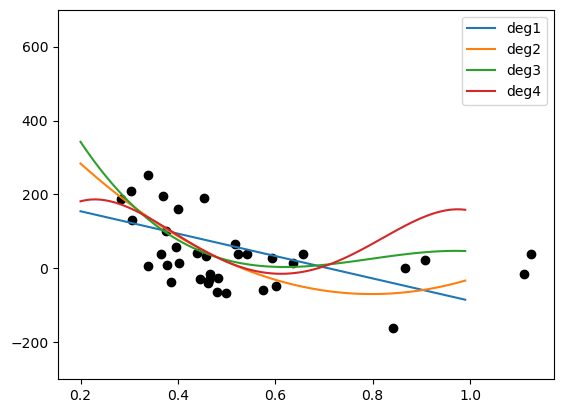

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c['sAge2'] = daf_c['sAge']**2
daf_c['sAge3'] = daf_c['sAge']**3
daf_c['sAge4'] = daf_c['sAge']**4
daf_c['sqrt_t'] = np.sqrt(daf_c['time_rel'])
sAge_values = np.arange(0.2,1,0.01)
sAge_values2 = sAge_values**2
sAge_values3 = sAge_values**3
sAge_values4 = sAge_values**4


for name, Subject in daf_c.groupby('Id'):
    model_id = Lm('Slope ~ time_rel', data=Subject)
    result = model_id.fit()
    coef = result['Estimate'][1]
    #age = Subject['sAge'].unique()[0]
    plt.scatter(age,coef, color='black')

#Sqrt deg 1:

model1 = Lm('Slope ~ time_rel * (sAge)', data=daf_c)
model1.fit()
plt.plot(sAge_values, model1.coefs['Estimate'][1] 
                                                + model1.coefs['Estimate'][3]*sAge_values 
                                                ,label = 'deg1')

#Sqrt deg 2:

model2 = Lm('Slope ~ time_rel * (sAge + sAge2)', data=daf_c)
model2.fit()
plt.plot(sAge_values, model2.coefs['Estimate'][1] 
                                                + model2.coefs['Estimate'][4]*sAge_values 
                                                + model2.coefs['Estimate'][5]*sAge_values2 
                                                ,label = 'deg2')

#Sqrt deg 3:

model3 = Lm('Slope ~ time_rel * (sAge + sAge2 + sAge3)', data=daf_c)
model3.fit()
plt.plot(sAge_values, model3.coefs['Estimate'][1] 
                                                + model3.coefs['Estimate'][5]*sAge_values
                                                + model3.coefs['Estimate'][6]*sAge_values2
                                                + model3.coefs['Estimate'][7]*sAge_values3
                                                ,label = 'deg3')


#Sqrt deg 4:

model4 = Lm('Slope ~ time_rel * (sAge + sAge2 + sAge3 + sAge4)', data=daf_c)
model4.fit()
plt.plot(sAge_values, model4.coefs['Estimate'][1] 
                                                + model4.coefs['Estimate'][6]*sAge_values 
                                                + model4.coefs['Estimate'][7]*sAge_values2
                                                + model4.coefs['Estimate'][8]*sAge_values3
                                                + model4.coefs['Estimate'][9]*sAge_values4
                                                ,label = 'deg4')

plt.ylim([-300,700])
plt.legend()
plt.show()


## LOG PRED PLOT

/tmp/ipykernel_2747101/38719194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/38719194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50


36
36
36


[]

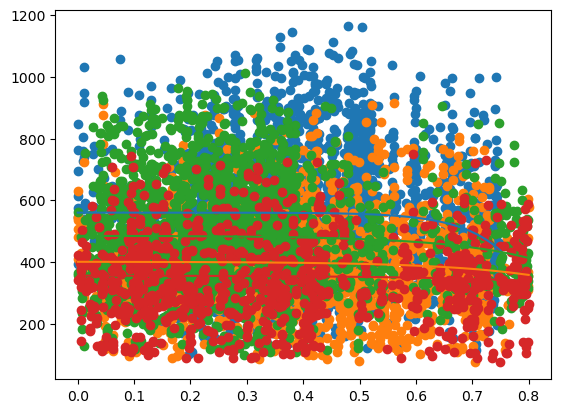

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50




def func(x, a, b, c):
    return a  + (b * np.exp(-x/c))

c = 0
f = 0
g = 0

for name, Subject in daf_c.groupby('Id'):
    c = c +1

    #plt.scatter(Subject.time_rel.values,Subject.Slope.values)
    x = Subject.time_rel.values
    y = Subject.Slope.values

      
    popt, pcov = curve_fit(func, x, y)
    g = g + 1
    #plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    coef = 1/popt[1]
    #age = Subject['sAge'].unique()[0]
    #plt.scatter(age,coef, color='black')

    f = f + 1
    #print(Subject['sAge'].unique()[0])
    #print(coef)

    if coef < -1:
        plt.scatter(Subject.time_rel.values,Subject.Slope.values)
        plt.plot(x, func(x,popt[0],popt[1],popt[2]))
    
    
print(c)
print(f)
print(g)
    
plt.plot()

# NO BINS MODEL

In [ ]:
daf_c = data_allF[data_allF['Group']=='C']
daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
daf_c['sAge'] = daf_c['Age']/50
daf_c.head()

/tmp/ipykernel_2747101/2859326843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['Id'] = daf_c['Subject'] + '_' + daf_c['Session'].astype(str)
/tmp/ipykernel_2747101/2859326843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf_c['sAge'] = daf_c['Age']/50


index   Wave     Start  NegPeak  MidCrossing  PosPeak      End  \
47  2831880  12769  0.673000  2423.08      2423.34  2423.57  2423.91   
48  2830582  11471  0.679381  2446.06      2446.33  2446.52  2447.30   
49  2833475  14364  0.679381  2446.04      2446.28  2446.48  2446.75   
50  2835266  16155  0.679381  2446.03      2446.27  2446.47  2446.75   
51  2836802  17691  0.679381  2446.02      2446.25  2446.47  2446.79   

    Duration  ValNegPeak  ValPosPeak         PTP       Slope  Frequency  \
47      1.11  -46.707747   32.177395   78.885141  303.404390   0.900901   
48      1.53  -89.754462   38.805616  128.560078  476.148436   0.653595   
49      0.98 -117.820316   70.414380  188.234695  784.311231   1.020408   
50      0.98 -111.116778   73.118567  184.235346  767.647273   1.020408   
51      1.02  -55.017271   42.728858   97.746129  424.983169   0.980392   

    Stage Channel  IdxChannel Group Subject Session    Age Machine  \
47      3      F3           7     C     C02       1  22.91       O   
48      3      F7           6     C     C02       1  22.91       O   
49      3      Fz           8     C     C02       1  22.91       O   
50      3      F4           9     C     C02       1  22.91       O   
51      3      F8          10     C     C02       1  22.91       O   

   ConfArousal Position  N3_times  time_rel     Id    sAge  
47           0        F     0.673  0.000000  C02_1  0.4582  
48           0        F     0.673  0.006381  C02_1  0.4582  
49           0        F     0.673  0.006381  C02_1  0.4582  
50           0        F     0.673  0.006381  C02_1  0.4582  
51           0        F     0.673  0.006381  C02_1  0.4582

(array([7629., 2848., 7436., 3114., 9113., 7836.,    0., 3870., 9012.,
        2762.,  492., 3834., 3674.,  902.,  466., 2500., 1130., 1701.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   88.,
         419.,    0.,  256.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 1803.]),
 array([0.284  , 0.30505, 0.3261 , 0.34715, 0.3682 , 0.38925, 0.4103 ,
        0.43135, 0.4524 , 0.47345, 0.4945 , 0.51555, 0.5366 , 0.55765,
        0.5787 , 0.59975, 0.6208 , 0.64185, 0.6629 , 0.68395, 0.705  ,
        0.72605, 0.7471 , 0.76815, 0.7892 , 0.81025, 0.8313 , 0.85235,
        0.8734 , 0.89445, 0.9155 , 0.93655, 0.9576 , 0.97865, 0.9997 ,
        1.02075, 1.0418 , 1.06285, 1.0839 , 1.10495, 1.126  ]),
 <BarContainer object of 40 artists>)

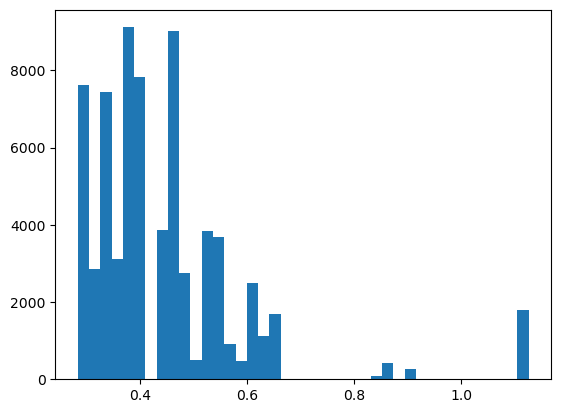

In [ ]:
plt.hist(daf_c['sAge'],40)

# UP TO deg 5

In [ ]:


model_sq = Lmer('Slope ~ time_rel * (sAge + I(sAge^2) + I(sAge^3) + I(sAge^4) + I(sAge^5)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~time_rel*(sAge+I(sAge^2)+I(sAge^3)+I(sAge^4)+I(sAge^5))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 70885	 Groups: {'Subject:Session': 36.0}

Log-likelihood: -468538.719 	 AIC: 937105.439

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   2783.254   52.757
Residual                      32268.013  179.633

No random effect correlations specified

Fixed effects:

                        Estimate         2.5_ci        97.5_ci             SE  \
(Intercept)           545.230148   -4205.704435    5296.164730    2423.990757   
time_rel              650.151609   -1359.763086    2660.066304    1025.485525   
sAge                 2439.862933  -40785.782097   45665.507963   22054.305779   
I(sAge^2)          -18231.543279 -168347.025651  131883.939093   76590.939199   
I(sAge^3)           44263.778946 -204135.601478  292663.159371  126736.706585   
I(s

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-182.42663567,   -9.98758106,  298.17521341, ...,   79.22585185,
         53.6560655 ,  190.42256289])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

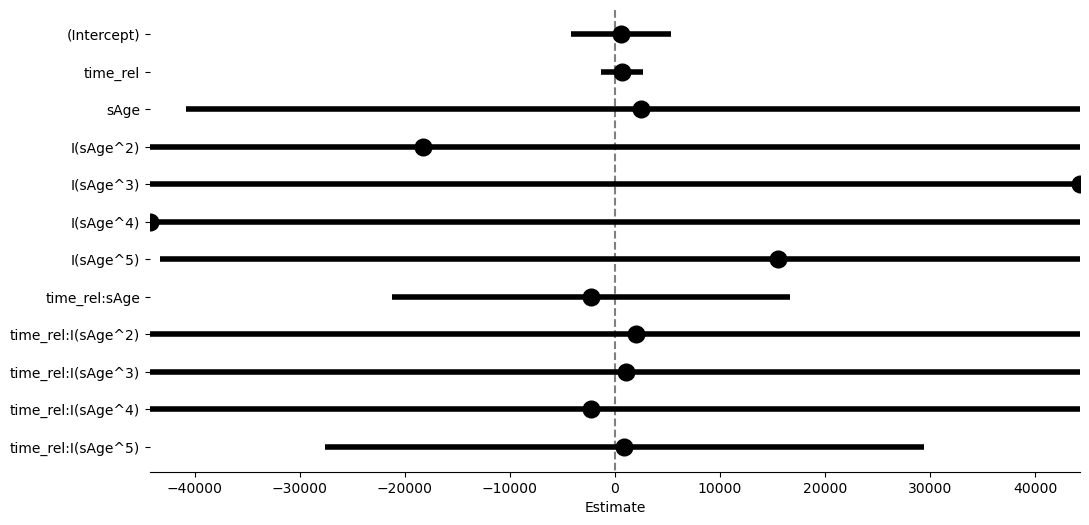

In [ ]:
model_sq.plot_summary()

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)

    times_out = []
    while len(times_out) < 15362:
        times_out.extend(times)


    times_out = times_out[:15362]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    


/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ConfArousal". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


ValueError: Length of values (70885) does not match length of index (15362)

<Figure size 1000x600 with 0 Axes>

# Up to 2 deg BOTH

In [ ]:
model_sq = Lmer('Slope ~ time_rel * (sAge + I(sAge^2)) + I(sqrt(time_rel)) * (sAge + I(sAge^2)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~time_rel*(sAge+I(sAge^2))+I(sqrt(time_rel))*(sAge+I(sAge^2))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 15362	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -102381.231 	 AIC: 204784.462

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   3953.781   62.879
Residual                      36005.746  189.752

No random effect correlations specified

Fixed effects:

                                Estimate       2.5_ci      97.5_ci  \
(Intercept)                   305.326359  -195.244724   805.897442   
time_rel                      -28.407445 -1186.611038  1129.796147   
sAge                           82.758625 -1890.453768  2055.971018   
I(sAge^2)                     148.229150 -1690.067729  1986.526028   
I(sqrt(time_rel))             813.992976  -606.018835  2234.004788   
time_rel:sAge                -603.437313 -5307.231487  4100.3568

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-247.15359379,  -48.63753464,   16.24605027, ...,  338.3323455 ,
        -76.30385387, -163.44301389])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

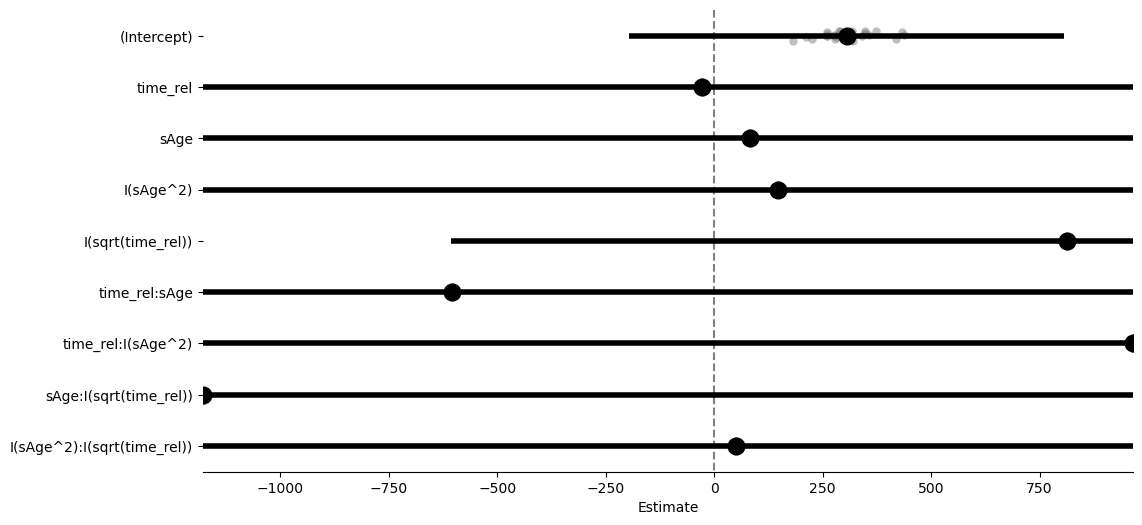

In [ ]:
model_sq.plot_summary()

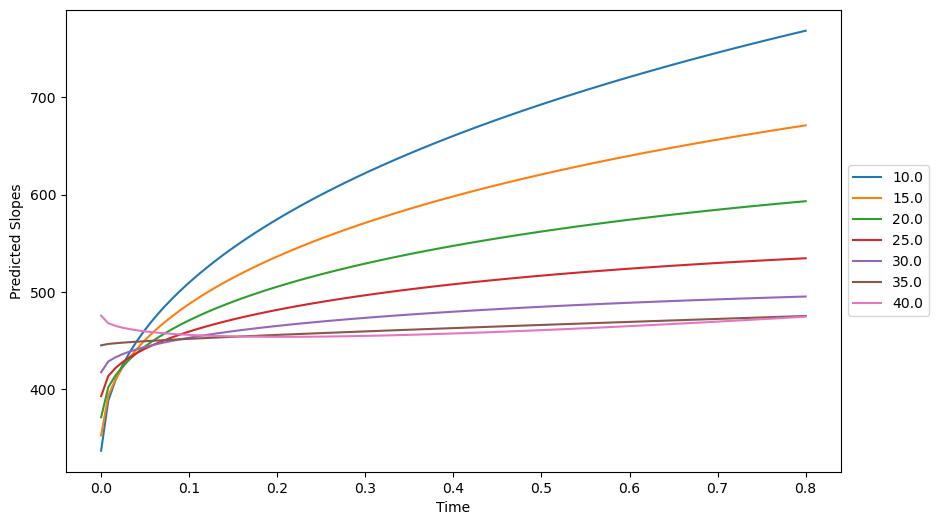

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 15362:
        times_out.extend(times)


    times_out = times_out[:15362]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    


# SQRT 5 Deg BOTH

In [ ]:


model_sq = Lmer('Slope ~ I(sqrt(time_rel)) * (sAge + I(sAge^2) +  I(sAge^3)) + time_rel * (sAge + I(sAge^2) + I(sAge^3)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals


Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~I(sqrt(time_rel))*(sAge+I(sAge^2)+I(sAge^3))+time_rel*(sAge+I(sAge^2)+I(sAge^3))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 15362	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -102349.974 	 AIC: 204727.949

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   3606.192   60.052
Residual                      36006.367  189.753

No random effect correlations specified

Fixed effects:

                                 Estimate        2.5_ci        97.5_ci  \
(Intercept)                     36.922543  -1799.604734    1873.449820   
I(sqrt(time_rel))             4522.657768   -701.952485    9747.268022   
sAge                          1904.851570  -9224.171641   13033.874781   
I(sAge^2)                    -3669.305727 -24993.713699   17655.102246   
I(sAge^3)                     2442.506488 -10357.671495   15242.684472   
time_rel            

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([-258.63390099,  -57.65674197,   10.43682056, ...,  336.66618106,
        -77.97283668, -165.11606538])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

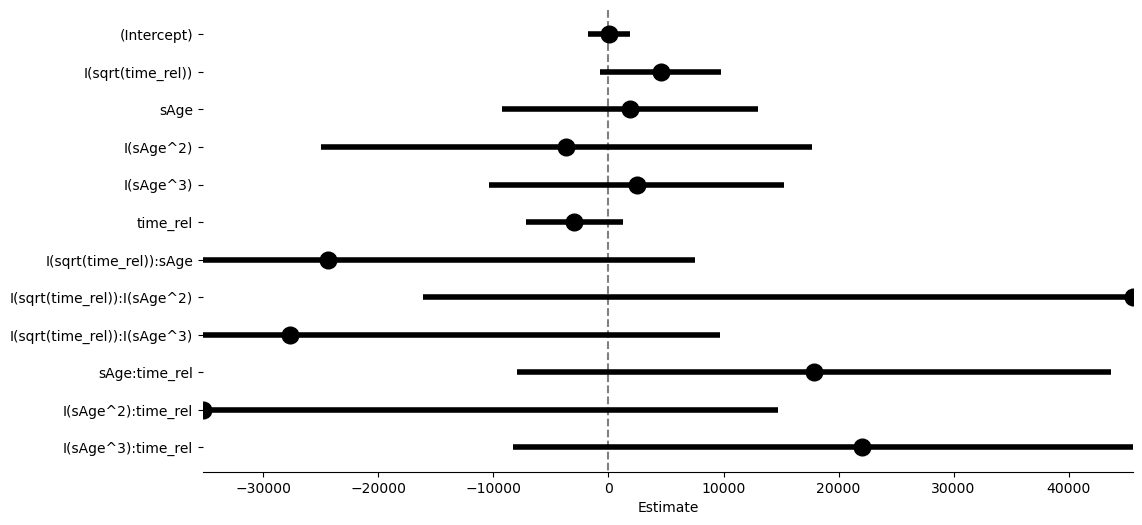

In [ ]:
model_sq.plot_summary()

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 123921:
        times_out.extend(times)


    times_out = times_out[:123921]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    

ValueError: operands could not be broadcast together with shapes (15362,) (123921,) 

<Figure size 1000x600 with 0 Axes>

# SQRT deg 2

In [ ]:
model_sq = Lmer('Slope ~ I(sqrt(time_rel)) * (sAge + I(sAge^2)) + (1|Subject:Session)', data=daf_c)



# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_sq.fit()
print(model_sq.coefs)


# Access model attributes
print('BIC: ' + str(model_sq.BIC))
model_sq.residuals

Linear mixed model fit by REML [’lmerMod’]
Formula: Slope~I(sqrt(time_rel))*(sAge+I(sAge^2))+(1|Subject:Session)

Family: gaussian	 Inference: parametric

Number of observations: 123921	 Groups: {'Subject:Session': 32.0}

Log-likelihood: -818610.531 	 AIC: 1637237.061

Random effects:

                        Name        Var      Std
Subject:Session  (Intercept)   4269.829   65.344
Residual                      31984.732  178.843

No random effect correlations specified

Fixed effects:

                                Estimate       2.5_ci      97.5_ci  \
(Intercept)                   332.977855    58.379422   607.576289   
I(sqrt(time_rel))             644.881553   550.828292   738.934814   
sAge                           69.927264  -975.555671  1115.410200   
I(sAge^2)                     -11.091886  -945.498875   923.315104   
I(sqrt(time_rel)):sAge      -1453.831688 -1854.669336 -1052.994040   
I(sqrt(time_rel)):I(sAge^2)   913.942258   505.618396  1322.266121   

                 

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


array([  96.03910818,  119.93726911, -146.7354911 , ..., -129.03346606,
       -166.11564097, -278.91066559])

/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amoran/miniconda3/envs/yasa_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

<Axes: xlabel='Estimate'>

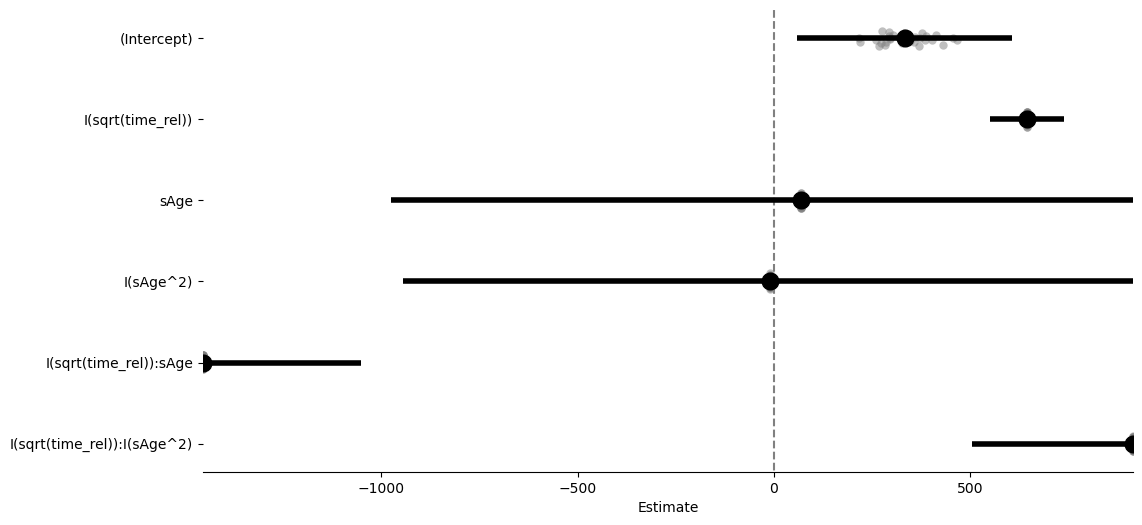

In [ ]:
model_sq.plot_summary()

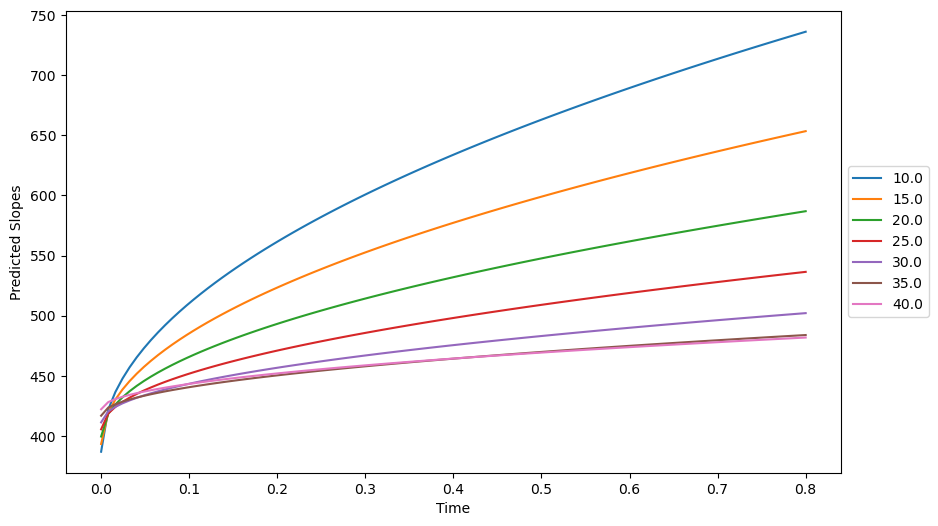

In [ ]:
plt.figure(figsize=(10, 6))

sAge_values = np.arange(0.2,0.8,0.1)
unique_time_rel_values = daf_c['time_rel'].unique()
123922

for age in sAge_values:
    times = np.linspace(min(daf_c['time_rel'].unique()), max(daf_c['time_rel'].unique()),100)
    
    times_out = []
    while len(times_out) < 123921:
        times_out.extend(times)


    times_out = times_out[:123921]

    df_pred = pd.DataFrame({'time_rel': times_out})
    df_pred['sAge'] = age
    df_pred['Slope'] = model_sq.predict(df_pred, skip_data_checks=True)
    plt.plot(df_pred['time_rel'][0:100],df_pred['Slope'][0:100], label = round(age*50,2))


plt.xlabel('Time')
plt.ylabel('Predicted Slopes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()   